In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import matplotlib.pyplot as plt

In [27]:
regional_emissions_final = {
    'f_hertz': pd.read_csv('../data/processed/analysis_final_f_hertz_15min_utc_202212312300_202412312245', sep=',', index_col=0),
    'amprion': pd.read_csv('../data/processed/analysis_final_amprion_15min_utc_202212312300_202412312245', sep=',', index_col=0),
    'tennet': pd.read_csv('../data/processed/analysis_final_tennet_15min_utc_202212312300_202412312245', sep=',', index_col=0),
    'transnetbw': pd.read_csv('../data/processed/analysis_final_transnet_bw_15min_utc_202212312300_202412312245', sep=',', index_col=0)
}


==================== ANALYSE FÜR F_HERTZ ====================
ADF Statistic für Delta Emissionen (f_hertz): -40.2113
p-value: 0.0000e+00
=> Die Zeitreihe ist stationär (H0 abgelehnt).
Starte Model-Fitting (das kann etwas dauern)...


/home/aklei/miniconda3/envs/ma/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:        total_emissions   No. Observations:                70175
Model:               MarkovRegression   Log Likelihood             -276278.085
Date:                Tue, 03 Feb 2026   AIC                         552568.170
Time:                        22:19:22   BIC                         552623.122
Sample:                    12-31-2022   HQIC                        552585.117
                         - 12-31-2024                                         
Covariance Type:               approx                                         
                                Regime 0 parameters                                 
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
total_generation     0.9893      0.001    944.720      0.000       0.987       0.991
sigma2              10.7573 

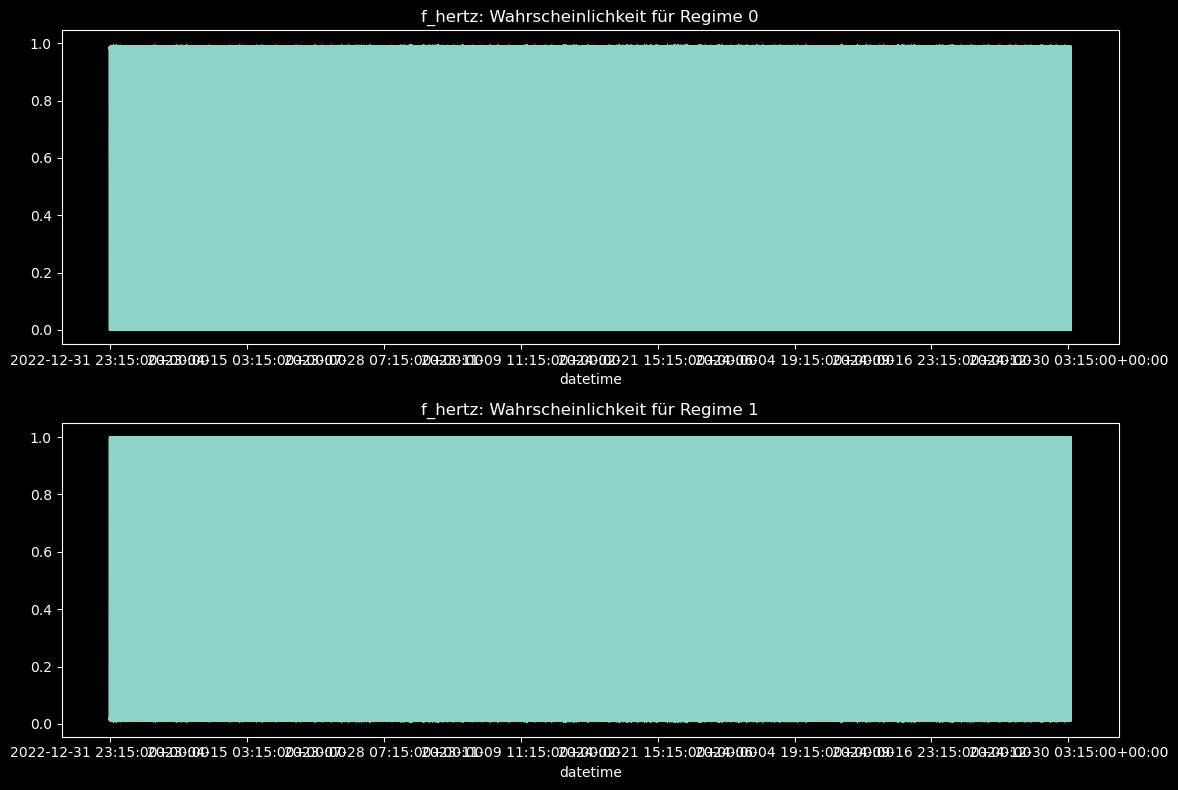


==================== ANALYSE FÜR AMPRION ====================
ADF Statistic für Delta Emissionen (amprion): -44.2060
p-value: 0.0000e+00
=> Die Zeitreihe ist stationär (H0 abgelehnt).
Starte Model-Fitting (das kann etwas dauern)...


/home/aklei/miniconda3/envs/ma/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:        total_emissions   No. Observations:                70175
Model:               MarkovRegression   Log Likelihood             -311148.005
Date:                Tue, 03 Feb 2026   AIC                         622308.010
Time:                        22:19:44   BIC                         622362.963
Sample:                    12-31-2022   HQIC                        622324.957
                         - 12-31-2024                                         
Covariance Type:               approx                                         
                                Regime 0 parameters                                 
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
total_generation     0.7859      0.002    491.109      0.000       0.783       0.789
sigma2              26.1639 

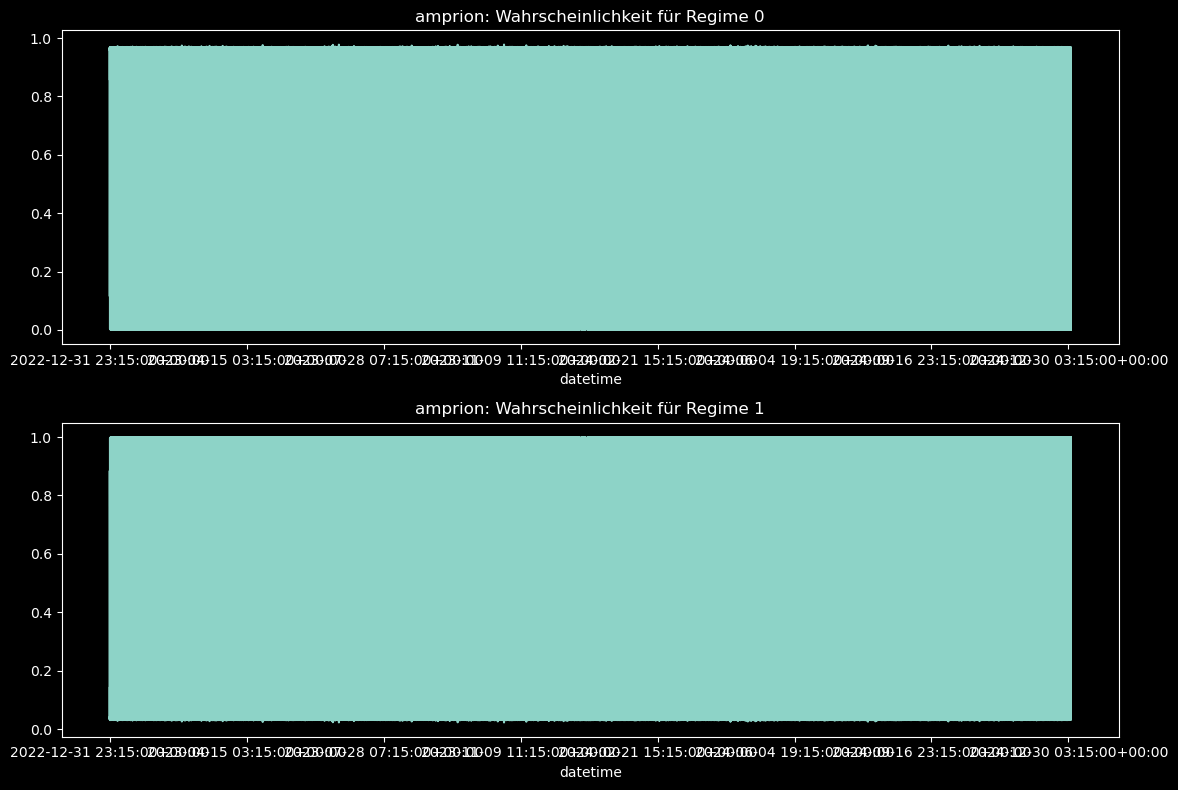


==================== ANALYSE FÜR TENNET ====================
ADF Statistic für Delta Emissionen (tennet): -45.8229
p-value: 0.0000e+00
=> Die Zeitreihe ist stationär (H0 abgelehnt).
Starte Model-Fitting (das kann etwas dauern)...


/home/aklei/miniconda3/envs/ma/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:        total_emissions   No. Observations:                70175
Model:               MarkovRegression   Log Likelihood             -206638.594
Date:                Tue, 03 Feb 2026   AIC                         413289.188
Time:                        22:20:05   BIC                         413344.141
Sample:                    12-31-2022   HQIC                        413306.135
                         - 12-31-2024                                         
Covariance Type:               approx                                         
                                Regime 0 parameters                                 
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
total_generation     0.6856      0.001   1221.521      0.000       0.685       0.687
sigma2               0.0526 

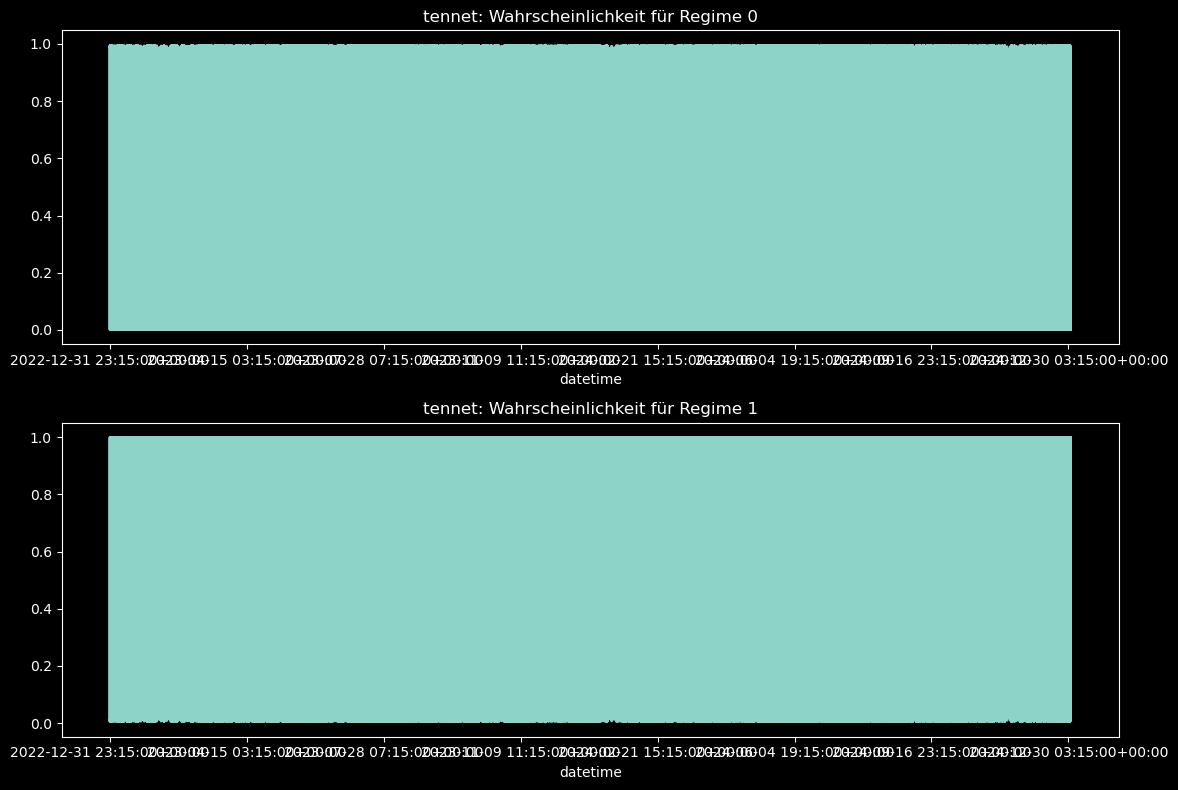


==================== ANALYSE FÜR TRANSNETBW ====================
ADF Statistic für Delta Emissionen (transnetbw): -40.8468
p-value: 0.0000e+00
=> Die Zeitreihe ist stationär (H0 abgelehnt).
Starte Model-Fitting (das kann etwas dauern)...


/home/aklei/miniconda3/envs/ma/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


Fehler beim Fitten von transnetbw: SVD did not converge


In [31]:
def check_stationarity(series, name="Series"):
    """Führt den Augmented Dickey-Fuller Test durch."""
    result = adfuller(series.dropna())
    print(f"ADF Statistic für {name}: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4e}")
    if result[1] < 0.05:
        print("=> Die Zeitreihe ist stationär (H0 abgelehnt).")
    else:
        print("=> Die Zeitreihe ist NICHT stationär (H0 nicht abgelehnt). -> Differenzen bilden!")

def fit_msdr_model(df, region_name, k_regimes=2):
    print(f"\n{'='*20} ANALYSE FÜR {region_name.upper()} {'='*20}")

    # 1. Datenvorbereitung: Erste Differenzen bilden
    # Wir nehmen an, df hat 'total_emissions' und 'total_generation'
    # Wir nutzen dropna(), da die erste Zeile durch Diff NaN wird
    df_diff = df[['total_emissions', 'total_generation']].diff().dropna()

    # Optional: Unendliche Werte entfernen (falls Division durch 0 irgendwo auftrat, unwahrscheinlich hier)
    df_diff = df_diff.replace([np.inf, -np.inf], np.nan).dropna()

    # 2. Stationaritäts-Check (nur zur Info, wir wissen, dass Diff meist stationär ist)
    # Wir testen kurz y (Emissionen)
    check_stationarity(df_diff['total_emissions'], f"Delta Emissionen ({region_name})")

    # 3. Modell-Spezifikation
    # Y = Delta Emissionen
    # X = Delta Konventionelle Erzeugung (total_generation)

    # HINWEIS: Wir skalieren die Daten ggf. für numerische Stabilität,
    # falls Konvergenzprobleme auftreten. Hier versuchen wir es erst roh.
    y = df_diff['total_emissions']
    X = df_diff['total_generation']

    # Das Modell:
    # k_regimes=2: Wir suchen 2 Zustände (z.B. Base vs. Peak)
    # trend='n': Kein konstanter Term (Intercept), da Delta-Werte um 0 schwanken
    # switching_variance=True: Wir erlauben unterschiedliche Volatilität
    try:
        model = MarkovRegression(
            endog=y,
            exog=X,
            k_regimes=k_regimes,
            trend='n',
            switching_variance=True
        )

        # Fitten des Modells
        # search_reps: Erhöht die Chance, das globale Optimum zu finden
        print("Starte Model-Fitting (das kann etwas dauern)...")
        res = model.fit(search_reps=20)

        # 4. Ergebnisse ausgeben
        print(res.summary())

        return res

    except Exception as e:
        print(f"Fehler beim Fitten von {region_name}: {e}")
        return None

# --- HAUPTANWENDUNG ---

# Dictionary für die Ergebnisse speichern
results_dict = {}

# Wir iterieren über deine vorbereiteten Dataframes
# regional_emissions_final ist das Dict, das wir im vorherigen Schritt erstellt haben
for name, df_final in regional_emissions_final.items():

    # Kurzer Check, ob Daten da sind
    if df_final.empty:
        print(f"Keine Daten für {name}, überspringe...")
        continue

    # Modell berechnen
    msdr_result = fit_msdr_model(df_final, name, k_regimes=2)

    if msdr_result:
        results_dict[name] = msdr_result

        # 5. Visualisierung der Regime-Wahrscheinlichkeiten (Beispielplot)
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))

        # Plot der Regime-Wahrscheinlichkeiten
        # Zeigt an, wann das Modell glaubt, in welchem Zustand zu sein
        msdr_result.smoothed_marginal_probabilities[0].plot(
            ax=axes[0], title=f"{name}: Wahrscheinlichkeit für Regime 0"
        )
        msdr_result.smoothed_marginal_probabilities[1].plot(
            ax=axes[1], title=f"{name}: Wahrscheinlichkeit für Regime 1"
        )

        plt.tight_layout()
        plt.show()

In [26]:
# Neue Funktion für stündliches Fitting
def fit_msdr_hourly(df_15min, region_name):
    print(f"\n{'='*20} STUNDEN-ANALYSE FÜR {region_name.upper()} {'='*20}")

    # 1. Aggregation auf Stunden (Summe bilden)
    # Wir summieren Erzeugung und Emissionen pro Stunde auf
    df_hourly = df_15min[['total_emissions', 'total_generation']].resample('1h').sum()

    # 2. Differenzen bilden (Jetzt auf Stundenbasis!)
    df_diff = df_hourly.diff().dropna()

    # Optional: Outlier entfernen (alles was weiter als 3 Std-Abweichungen weg ist)
    # Das hilft oft, wenn das Modell "zickig" ist
    # (Kannst du erstmal auskommentiert lassen, falls es auch so läuft)
    # df_diff = df_diff[(np.abs(stats.zscore(df_diff)) < 3).all(axis=1)]

    # 3. Modell
    y = df_diff['total_emissions']
    X = df_diff['total_generation']

    try:
        model = MarkovRegression(
            endog=y,
            exog=X,
            k_regimes=2,
            trend='n',
            switching_variance=True
        )

        print("Fitte stündliches Modell...")
        res = model.fit(search_reps=50) # Mehr Reps für besseres Ergebnis
        print(res.summary())
        return res

    except Exception as e:
        print(f"Fehler: {e}")
        return None

# --- ANWENDUNG ---
hourly_results = {}

for name, df_emi in regional_emissions_final.items():
    # Wir bauen den DF wieder zusammen (wie vorhin)
    df_analysis = pd.DataFrame()
    df_analysis['total_emissions'] = df_emi['total_emissions']
    df_analysis['total_generation'] = regions[name]['total_generation'] # Holen aus SMARD Dict

    df_analysis = df_analysis.dropna()

    if df_analysis.empty: continue

    # Hier rufen wir jetzt die STUNDEN-Funktion auf
    res = fit_msdr_hourly(df_analysis, name)

    if res:
        hourly_results[name] = res

        # Plotten
        fig, axes = plt.subplots(2, 1, figsize=(10, 5))
        res.smoothed_marginal_probabilities[0].plot(ax=axes[0], title=f"{name} (Hourly): Regime 0")
        res.smoothed_marginal_probabilities[1].plot(ax=axes[1], title=f"{name} (Hourly): Regime 1")
        plt.tight_layout()
        plt.show()


==================== STUNDEN-ANALYSE FÜR F_HERTZ ====================


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'